In [4]:
import cv2
import sys
import os
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [5]:
cv2.__version__

'3.3.0'

In [6]:
from sklearn.neighbors import NearestNeighbors, DistanceMetric

In [7]:
landmarks_frame = pd.read_csv('./face_landmarks.csv')

In [8]:
def makeComputeTableVector(index):
    L = landmarks_frame.ix[index, 1:].as_matrix().astype('float').reshape(-1, 2).ravel()
    img_name = landmarks_frame.ix[index, 0]
    T = io.imread(img_name).ravel()
    tmp_vector = []
    tmp_vector.append(index)
    tmp_vector += L.tolist()
    tmp_vector += T.tolist()
    return tmp_vector

In [9]:
knn_face_vectors = []
for i in range(len(landmarks_frame)):
    knn_face_vectors.append(makeComputeTableVector(i))

In [11]:
# d(A, B) = Lambda * ||La - Lb|| + ||Ta - Tb||

from numpy import linalg as LA

def mydist(x, y):
    x = np.array(x).astype('int')
    y = np.array(y).astype('int')
    return 10 * LA.norm(x[1:137] - y[1:137]) + LA.norm(x[137:] - y[137:])  

knn = NearestNeighbors(n_neighbors=16, algorithm='ball_tree', metric=mydist)
knn.fit(knn_face_vectors)
distance, indicies = knn.kneighbors(knn_face_vectors)

In [28]:
indicies[5]

array([  5,  79,  77,  91, 151,  98,  73])

In [30]:
makeFace(5, 8)

In [12]:
#! /usr/bin/env python
## refactoring version

import sys
import numpy as np
import cv2

# Read points from text file
def readPoints(path) :
    # Create an array of points.
    points = [];
    
    # Read points
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))
    

    return points

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p)
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
    
    count= 0    
    
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            count = count + 1 
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri
        

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    

def makeFace(index1, index2):
    # Make sure OpenCV is version 3.0 or above
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

    if int(major_ver) < 3 :
        print >>sys.stderr, 'ERROR: Script needs OpenCV 3.0 or higher'
        sys.exit(1)
    
    img_name = landmarks_frame.ix[index1, 0]
    landmarks = landmarks_frame.ix[index1, 1:].as_matrix().astype('int')
    landmarks = landmarks.reshape(-1, 2) # (68, 2)
    
    img_name_2 = landmarks_frame.ix[index2, 0]
    landmarks_2 = landmarks_frame.ix[index2, 1:].as_matrix().astype('int')
    landmarks_2 = landmarks_2.reshape(-1, 2) # (68, 2)
    
    # Read images
    img1 = io.imread(img_name);
    img2 = io.imread(img_name_2);
    img1Warped = np.copy(img2);    
    
    # Read array of corresponding points
    points1 = [tuple(l) for l in landmarks]
    points2 = [tuple(l) for l in landmarks_2]
    
    # Find convex hull
    hull1 = []
    hull2 = []

    hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
    
    # Find delanauy traingulation for convex hull points
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
    
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
    
    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        
        warpTriangle(img1, img1Warped, t1, t2)
            
    # Calculate Mask
    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    
    mask = np.zeros(img2.shape, dtype = img2.dtype)  
    
    cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    
    r = cv2.boundingRect(np.float32([hull2]))    
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))    
    
    # Clone seamlessly.
    output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)
    
    cv2.imwrite("./faces_generate/Genface-" + str(index1) + "_" + str(index2) + ".jpg", cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
#     plt.imshow(output)

In [13]:
import itertools

isGeneratedPair = {}
length = len(landmarks_frame)
for idx in range(length):
    mypermutation = itertools.permutations(indicies[idx], 2)
    for i, points in enumerate(mypermutation):
        if points in isGeneratedPair:
            sys.stdout.write('\r'+ '%d/%d : pass   '%(idx, length))
        else:
            try:
                isGeneratedPair[points] = True
                makeFace(points[0], points[1])
                sys.stdout.write('\r'+ '%d/%d : success'%(idx, length))
            except:
                sys.stdout.write('\r'+ '%d/%d : error   '%(idx, length))
        

953/954 : pass    

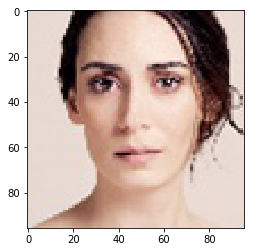

In [26]:
n = 30
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2) # (68, 2)
plt.imshow(io.imread(img_name))